# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

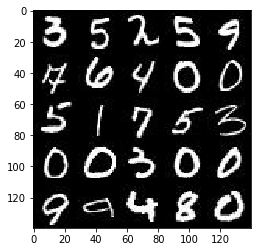

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

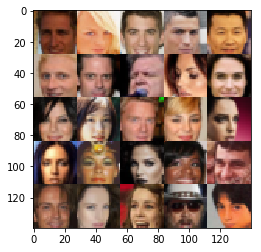

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.5.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    z_input = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, lrelu_alpha=0.2):
        return tf.maximum(lrelu_alpha * x, x)

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input is N*28*28*3
        # output = N*14*14*64
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer1 = leaky_relu(layer1, alpha)
        
        # output = N*7*7*128
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = leaky_relu(layer2, alpha)
        
        # output = N*4*4*256
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same',
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = leaky_relu(layer3, alpha)
                
        flat = tf.layers.flatten(layer3)
        logits = tf.layers.dense(flat, 1,
                                )
        out = tf.sigmoid(logits)      

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, reuse=None):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    local_reuse = (not is_train) if not reuse else reuse
    
    with tf.variable_scope("generator", reuse=local_reuse):
        
        # input: N*z_dim
        # output: 7*7*256
        layer1 = tf.layers.dense(z, 7*7*256, 
                                 kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer1 = tf.reshape(layer1, (-1, 7, 7, 256))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = leaky_relu(layer1, alpha)
        
        # output: N*14*14*128
        layer2 = tf.layers.conv2d_transpose(layer1, 128, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = leaky_relu(layer2, alpha)
        
        # output: N*28*28*64
        layer3 = tf.layers.conv2d_transpose(layer2, 64, 5, strides=2, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = leaky_relu(layer3, alpha)     
        
        # output: N*28*28*3
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.random_uniform_initializer(-0.01, 0.01))
        
        out = tf.tanh(logits)        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    ctrl = [op for op in ops if op.name.startswith('generator')]

    with tf.control_dependencies(ctrl):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):

        self.input_real, self.input_z, learn_rate = model_inputs(*real_size,  z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)    
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1,
          get_batches, data_shape, data_image_mode, print_every=1, show_every=5):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    steps = 0
    e = 0
    samples, losses = [], []
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            e += 1
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images
                                                   })
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    print("Epoch {}/{}...".format(e, epoch_count),
                          "Iteration {}".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))   
                    
                    if steps % show_every == 0:
                        out_channel_dim = net.input_real.shape[-1]
                        image_mode = 'L' if out_channel_dim == 1 else 'RGB'
                        gen_samples = sess.run(
                                       generator(net.input_z, out_channel_dim, reuse=True, is_train=False),
                                       feed_dict={net.input_z: batch_z})
                        samples.append(gen_samples)
                        show_generator_output(sess, 36, net.input_z, out_channel_dim, image_mode)
              

In [13]:
device = tf.device('/gpu:0')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Iteration 10 Discriminator Loss: 1.2023... Generator Loss: 0.6469
Epoch 1/2... Iteration 20 Discriminator Loss: 1.6504... Generator Loss: 2.9328
Epoch 1/2... Iteration 30 Discriminator Loss: 0.9287... Generator Loss: 0.9584
Epoch 1/2... Iteration 40 Discriminator Loss: 0.9784... Generator Loss: 0.8485
Epoch 1/2... Iteration 50 Discriminator Loss: 1.1129... Generator Loss: 1.1381
Epoch 1/2... Iteration 60 Discriminator Loss: 1.0428... Generator Loss: 0.5472
Epoch 1/2... Iteration 70 Discriminator Loss: 1.0255... Generator Loss: 0.8305
Epoch 1/2... Iteration 80 Discriminator Loss: 0.9904... Generator Loss: 0.9262
Epoch 1/2... Iteration 90 Discriminator Loss: 1.0606... Generator Loss: 0.7102
Epoch 1/2... Iteration 100 Discriminator Loss: 1.1887... Generator Loss: 1.2313


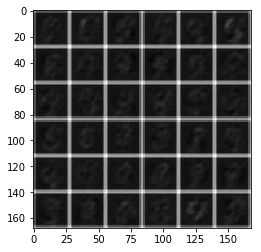

Epoch 1/2... Iteration 110 Discriminator Loss: 1.2570... Generator Loss: 0.5436
Epoch 1/2... Iteration 120 Discriminator Loss: 0.8966... Generator Loss: 0.9445
Epoch 1/2... Iteration 130 Discriminator Loss: 1.1573... Generator Loss: 0.5483
Epoch 1/2... Iteration 140 Discriminator Loss: 1.6065... Generator Loss: 0.3118
Epoch 1/2... Iteration 150 Discriminator Loss: 1.3396... Generator Loss: 1.9468
Epoch 1/2... Iteration 160 Discriminator Loss: 0.9524... Generator Loss: 0.8750
Epoch 1/2... Iteration 170 Discriminator Loss: 0.9119... Generator Loss: 0.9268
Epoch 1/2... Iteration 180 Discriminator Loss: 0.7815... Generator Loss: 1.0341
Epoch 1/2... Iteration 190 Discriminator Loss: 0.8727... Generator Loss: 0.8444
Epoch 1/2... Iteration 200 Discriminator Loss: 0.9242... Generator Loss: 1.0919


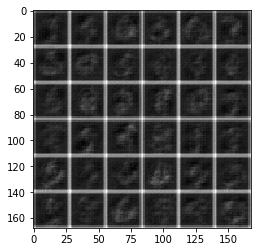

Epoch 1/2... Iteration 210 Discriminator Loss: 1.4038... Generator Loss: 0.3553
Epoch 1/2... Iteration 220 Discriminator Loss: 0.7922... Generator Loss: 2.0279
Epoch 1/2... Iteration 230 Discriminator Loss: 0.7366... Generator Loss: 2.0581
Epoch 1/2... Iteration 240 Discriminator Loss: 0.7866... Generator Loss: 1.0429
Epoch 1/2... Iteration 250 Discriminator Loss: 0.7327... Generator Loss: 1.6286
Epoch 1/2... Iteration 260 Discriminator Loss: 0.6973... Generator Loss: 2.1056
Epoch 1/2... Iteration 270 Discriminator Loss: 0.8340... Generator Loss: 0.8060
Epoch 1/2... Iteration 280 Discriminator Loss: 0.9166... Generator Loss: 0.7695
Epoch 1/2... Iteration 290 Discriminator Loss: 0.7205... Generator Loss: 1.0351
Epoch 1/2... Iteration 300 Discriminator Loss: 0.6726... Generator Loss: 1.5178


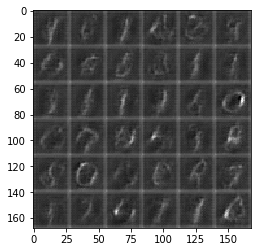

Epoch 1/2... Iteration 310 Discriminator Loss: 1.3324... Generator Loss: 0.4395
Epoch 1/2... Iteration 320 Discriminator Loss: 1.0303... Generator Loss: 0.6328
Epoch 1/2... Iteration 330 Discriminator Loss: 1.2477... Generator Loss: 0.4236
Epoch 1/2... Iteration 340 Discriminator Loss: 0.6637... Generator Loss: 1.3377
Epoch 1/2... Iteration 350 Discriminator Loss: 1.1256... Generator Loss: 1.8628
Epoch 1/2... Iteration 360 Discriminator Loss: 0.7898... Generator Loss: 0.9007
Epoch 1/2... Iteration 370 Discriminator Loss: 1.2082... Generator Loss: 0.4672
Epoch 1/2... Iteration 380 Discriminator Loss: 0.3704... Generator Loss: 1.6767
Epoch 1/2... Iteration 390 Discriminator Loss: 0.8001... Generator Loss: 1.0278
Epoch 1/2... Iteration 400 Discriminator Loss: 2.7439... Generator Loss: 5.0970


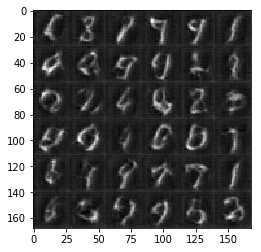

Epoch 1/2... Iteration 410 Discriminator Loss: 0.5874... Generator Loss: 1.2048
Epoch 1/2... Iteration 420 Discriminator Loss: 0.9490... Generator Loss: 0.7101
Epoch 1/2... Iteration 430 Discriminator Loss: 1.0159... Generator Loss: 0.6440
Epoch 1/2... Iteration 440 Discriminator Loss: 1.0130... Generator Loss: 0.6401
Epoch 1/2... Iteration 450 Discriminator Loss: 0.5868... Generator Loss: 1.1484
Epoch 1/2... Iteration 460 Discriminator Loss: 0.4589... Generator Loss: 1.4745
Epoch 1/2... Iteration 470 Discriminator Loss: 1.5215... Generator Loss: 3.0330
Epoch 1/2... Iteration 480 Discriminator Loss: 0.8983... Generator Loss: 0.9618
Epoch 1/2... Iteration 490 Discriminator Loss: 1.0981... Generator Loss: 0.5425
Epoch 1/2... Iteration 500 Discriminator Loss: 0.5273... Generator Loss: 1.4202


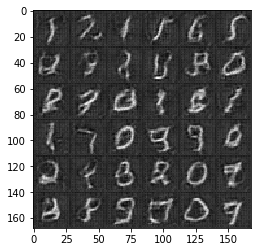

Epoch 1/2... Iteration 510 Discriminator Loss: 0.4021... Generator Loss: 2.2361
Epoch 1/2... Iteration 520 Discriminator Loss: 0.4842... Generator Loss: 1.3749
Epoch 1/2... Iteration 530 Discriminator Loss: 1.0864... Generator Loss: 0.5349
Epoch 1/2... Iteration 540 Discriminator Loss: 0.8766... Generator Loss: 0.7451
Epoch 1/2... Iteration 550 Discriminator Loss: 1.0253... Generator Loss: 1.4397
Epoch 1/2... Iteration 560 Discriminator Loss: 0.6169... Generator Loss: 1.4771
Epoch 1/2... Iteration 570 Discriminator Loss: 0.2203... Generator Loss: 2.6575
Epoch 1/2... Iteration 580 Discriminator Loss: 0.5712... Generator Loss: 1.2178
Epoch 1/2... Iteration 590 Discriminator Loss: 0.2858... Generator Loss: 2.3312
Epoch 1/2... Iteration 600 Discriminator Loss: 0.6475... Generator Loss: 1.1093


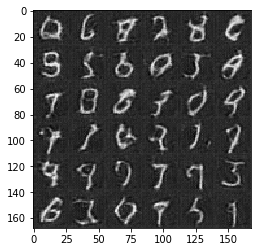

Epoch 1/2... Iteration 610 Discriminator Loss: 0.8242... Generator Loss: 0.7407
Epoch 1/2... Iteration 620 Discriminator Loss: 0.3832... Generator Loss: 1.5005
Epoch 1/2... Iteration 630 Discriminator Loss: 0.1278... Generator Loss: 3.0289
Epoch 1/2... Iteration 640 Discriminator Loss: 0.3606... Generator Loss: 3.1161
Epoch 1/2... Iteration 650 Discriminator Loss: 0.1567... Generator Loss: 3.1022
Epoch 1/2... Iteration 660 Discriminator Loss: 0.2549... Generator Loss: 2.2402
Epoch 1/2... Iteration 670 Discriminator Loss: 1.7223... Generator Loss: 0.4938
Epoch 1/2... Iteration 680 Discriminator Loss: 0.6094... Generator Loss: 1.1751
Epoch 1/2... Iteration 690 Discriminator Loss: 0.4998... Generator Loss: 1.4544
Epoch 1/2... Iteration 700 Discriminator Loss: 0.3378... Generator Loss: 3.0787


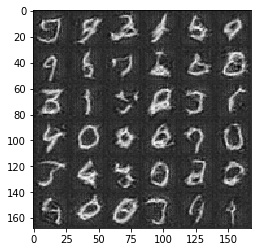

Epoch 1/2... Iteration 710 Discriminator Loss: 0.8994... Generator Loss: 0.6821
Epoch 1/2... Iteration 720 Discriminator Loss: 1.4024... Generator Loss: 0.4580
Epoch 1/2... Iteration 730 Discriminator Loss: 0.6808... Generator Loss: 1.2096
Epoch 1/2... Iteration 740 Discriminator Loss: 0.6424... Generator Loss: 1.0624
Epoch 1/2... Iteration 750 Discriminator Loss: 0.1864... Generator Loss: 2.2785
Epoch 1/2... Iteration 760 Discriminator Loss: 0.8043... Generator Loss: 0.8746
Epoch 1/2... Iteration 770 Discriminator Loss: 0.2831... Generator Loss: 2.1750
Epoch 1/2... Iteration 780 Discriminator Loss: 0.0981... Generator Loss: 4.2875
Epoch 1/2... Iteration 790 Discriminator Loss: 0.1341... Generator Loss: 4.2802
Epoch 1/2... Iteration 800 Discriminator Loss: 0.7246... Generator Loss: 0.8920


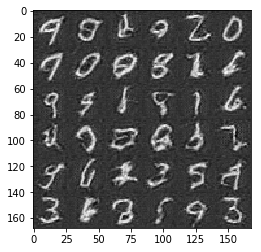

Epoch 1/2... Iteration 810 Discriminator Loss: 0.3717... Generator Loss: 1.8557
Epoch 1/2... Iteration 820 Discriminator Loss: 0.5894... Generator Loss: 2.0594
Epoch 1/2... Iteration 830 Discriminator Loss: 1.1100... Generator Loss: 0.8177
Epoch 1/2... Iteration 840 Discriminator Loss: 0.6539... Generator Loss: 1.4902
Epoch 1/2... Iteration 850 Discriminator Loss: 0.6703... Generator Loss: 1.0040
Epoch 1/2... Iteration 860 Discriminator Loss: 0.3736... Generator Loss: 1.5953
Epoch 1/2... Iteration 870 Discriminator Loss: 0.4001... Generator Loss: 3.9235
Epoch 1/2... Iteration 880 Discriminator Loss: 0.5726... Generator Loss: 1.1431
Epoch 1/2... Iteration 890 Discriminator Loss: 0.1729... Generator Loss: 3.6451
Epoch 1/2... Iteration 900 Discriminator Loss: 0.0626... Generator Loss: 3.6908


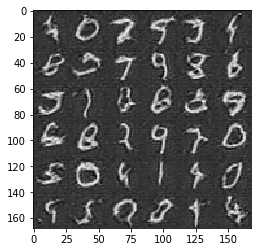

Epoch 1/2... Iteration 910 Discriminator Loss: 6.7970... Generator Loss: 6.7066
Epoch 1/2... Iteration 920 Discriminator Loss: 0.8875... Generator Loss: 1.4942
Epoch 1/2... Iteration 930 Discriminator Loss: 1.0757... Generator Loss: 1.8894
Epoch 2/2... Iteration 940 Discriminator Loss: 0.6586... Generator Loss: 2.4992
Epoch 2/2... Iteration 950 Discriminator Loss: 0.3808... Generator Loss: 2.0577
Epoch 2/2... Iteration 960 Discriminator Loss: 0.8453... Generator Loss: 0.8316
Epoch 2/2... Iteration 970 Discriminator Loss: 0.4180... Generator Loss: 1.5690
Epoch 2/2... Iteration 980 Discriminator Loss: 0.1930... Generator Loss: 2.5663
Epoch 2/2... Iteration 990 Discriminator Loss: 0.1322... Generator Loss: 3.7177
Epoch 2/2... Iteration 1000 Discriminator Loss: 1.6381... Generator Loss: 5.9969


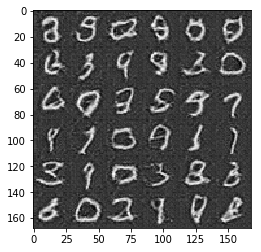

Epoch 2/2... Iteration 1010 Discriminator Loss: 0.4904... Generator Loss: 1.6844
Epoch 2/2... Iteration 1020 Discriminator Loss: 0.7126... Generator Loss: 1.1487
Epoch 2/2... Iteration 1030 Discriminator Loss: 0.9995... Generator Loss: 0.7041
Epoch 2/2... Iteration 1040 Discriminator Loss: 0.5704... Generator Loss: 1.3312
Epoch 2/2... Iteration 1050 Discriminator Loss: 0.3093... Generator Loss: 1.9693
Epoch 2/2... Iteration 1060 Discriminator Loss: 0.1644... Generator Loss: 3.3053
Epoch 2/2... Iteration 1070 Discriminator Loss: 0.3086... Generator Loss: 1.9967
Epoch 2/2... Iteration 1080 Discriminator Loss: 0.0935... Generator Loss: 3.2387
Epoch 2/2... Iteration 1090 Discriminator Loss: 0.2728... Generator Loss: 1.8933
Epoch 2/2... Iteration 1100 Discriminator Loss: 0.1190... Generator Loss: 3.7775


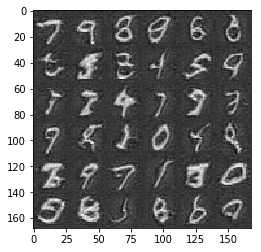

Epoch 2/2... Iteration 1110 Discriminator Loss: 1.4437... Generator Loss: 4.3505
Epoch 2/2... Iteration 1120 Discriminator Loss: 0.7526... Generator Loss: 1.1943
Epoch 2/2... Iteration 1130 Discriminator Loss: 0.4101... Generator Loss: 1.7317
Epoch 2/2... Iteration 1140 Discriminator Loss: 0.3915... Generator Loss: 1.5911
Epoch 2/2... Iteration 1150 Discriminator Loss: 0.2535... Generator Loss: 2.5554
Epoch 2/2... Iteration 1160 Discriminator Loss: 0.3625... Generator Loss: 2.1231
Epoch 2/2... Iteration 1170 Discriminator Loss: 0.3496... Generator Loss: 2.3982
Epoch 2/2... Iteration 1180 Discriminator Loss: 0.1153... Generator Loss: 3.4922
Epoch 2/2... Iteration 1190 Discriminator Loss: 0.2451... Generator Loss: 4.8348
Epoch 2/2... Iteration 1200 Discriminator Loss: 0.7817... Generator Loss: 0.9424


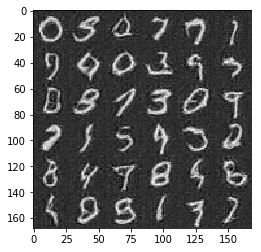

Epoch 2/2... Iteration 1210 Discriminator Loss: 0.1983... Generator Loss: 2.1464
Epoch 2/2... Iteration 1220 Discriminator Loss: 0.4974... Generator Loss: 1.2632
Epoch 2/2... Iteration 1230 Discriminator Loss: 0.6594... Generator Loss: 2.9078
Epoch 2/2... Iteration 1240 Discriminator Loss: 1.1517... Generator Loss: 0.6617
Epoch 2/2... Iteration 1250 Discriminator Loss: 0.1996... Generator Loss: 2.6511
Epoch 2/2... Iteration 1260 Discriminator Loss: 0.5500... Generator Loss: 1.0640
Epoch 2/2... Iteration 1270 Discriminator Loss: 0.1404... Generator Loss: 2.9769
Epoch 2/2... Iteration 1280 Discriminator Loss: 0.3125... Generator Loss: 1.8202
Epoch 2/2... Iteration 1290 Discriminator Loss: 0.0528... Generator Loss: 4.4047
Epoch 2/2... Iteration 1300 Discriminator Loss: 0.2379... Generator Loss: 2.0520


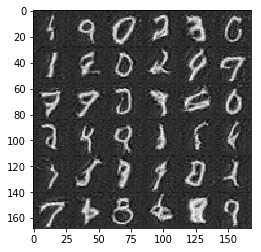

Epoch 2/2... Iteration 1310 Discriminator Loss: 0.2423... Generator Loss: 2.0111
Epoch 2/2... Iteration 1320 Discriminator Loss: 0.2005... Generator Loss: 5.3365
Epoch 2/2... Iteration 1330 Discriminator Loss: 0.8402... Generator Loss: 1.2451
Epoch 2/2... Iteration 1340 Discriminator Loss: 2.0399... Generator Loss: 0.2751
Epoch 2/2... Iteration 1350 Discriminator Loss: 0.8541... Generator Loss: 0.8726
Epoch 2/2... Iteration 1360 Discriminator Loss: 1.1788... Generator Loss: 3.0664
Epoch 2/2... Iteration 1370 Discriminator Loss: 1.2539... Generator Loss: 0.5309
Epoch 2/2... Iteration 1380 Discriminator Loss: 0.5281... Generator Loss: 1.3338
Epoch 2/2... Iteration 1390 Discriminator Loss: 0.5371... Generator Loss: 1.2767
Epoch 2/2... Iteration 1400 Discriminator Loss: 0.3641... Generator Loss: 1.7723


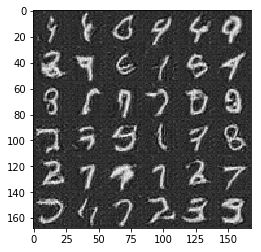

Epoch 2/2... Iteration 1410 Discriminator Loss: 0.1612... Generator Loss: 3.0065
Epoch 2/2... Iteration 1420 Discriminator Loss: 0.6446... Generator Loss: 1.0101
Epoch 2/2... Iteration 1430 Discriminator Loss: 0.1964... Generator Loss: 2.5673
Epoch 2/2... Iteration 1440 Discriminator Loss: 1.5111... Generator Loss: 5.1319
Epoch 2/2... Iteration 1450 Discriminator Loss: 0.7077... Generator Loss: 1.0772
Epoch 2/2... Iteration 1460 Discriminator Loss: 0.4356... Generator Loss: 2.9366
Epoch 2/2... Iteration 1470 Discriminator Loss: 0.4140... Generator Loss: 2.9719
Epoch 2/2... Iteration 1480 Discriminator Loss: 0.1281... Generator Loss: 2.8555
Epoch 2/2... Iteration 1490 Discriminator Loss: 0.9429... Generator Loss: 0.9192
Epoch 2/2... Iteration 1500 Discriminator Loss: 0.8732... Generator Loss: 1.2320


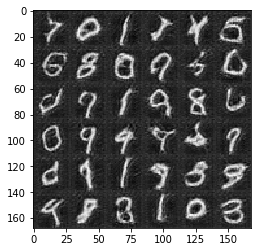

Epoch 2/2... Iteration 1510 Discriminator Loss: 0.8152... Generator Loss: 0.8777
Epoch 2/2... Iteration 1520 Discriminator Loss: 0.5816... Generator Loss: 1.2975
Epoch 2/2... Iteration 1530 Discriminator Loss: 1.1660... Generator Loss: 0.6279
Epoch 2/2... Iteration 1540 Discriminator Loss: 0.4942... Generator Loss: 2.1446
Epoch 2/2... Iteration 1550 Discriminator Loss: 0.2894... Generator Loss: 1.7996
Epoch 2/2... Iteration 1560 Discriminator Loss: 0.7828... Generator Loss: 0.9559
Epoch 2/2... Iteration 1570 Discriminator Loss: 0.2316... Generator Loss: 4.8127
Epoch 2/2... Iteration 1580 Discriminator Loss: 0.6004... Generator Loss: 1.1472
Epoch 2/2... Iteration 1590 Discriminator Loss: 0.1113... Generator Loss: 3.3338
Epoch 2/2... Iteration 1600 Discriminator Loss: 0.4258... Generator Loss: 1.4593


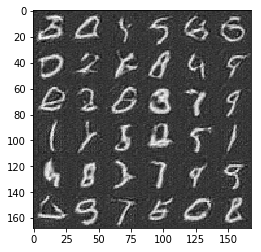

Epoch 2/2... Iteration 1610 Discriminator Loss: 0.1305... Generator Loss: 2.9072
Epoch 2/2... Iteration 1620 Discriminator Loss: 0.0472... Generator Loss: 5.0784
Epoch 2/2... Iteration 1630 Discriminator Loss: 0.0486... Generator Loss: 5.1585
Epoch 2/2... Iteration 1640 Discriminator Loss: 0.1924... Generator Loss: 2.2267
Epoch 2/2... Iteration 1650 Discriminator Loss: 0.1452... Generator Loss: 2.5191
Epoch 2/2... Iteration 1660 Discriminator Loss: 0.0949... Generator Loss: 3.2435
Epoch 2/2... Iteration 1670 Discriminator Loss: 3.2605... Generator Loss: 0.0929
Epoch 2/2... Iteration 1680 Discriminator Loss: 0.7492... Generator Loss: 1.0767
Epoch 2/2... Iteration 1690 Discriminator Loss: 0.9840... Generator Loss: 2.6594
Epoch 2/2... Iteration 1700 Discriminator Loss: 0.5052... Generator Loss: 1.4726


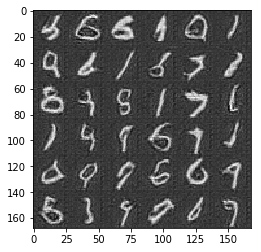

Epoch 2/2... Iteration 1710 Discriminator Loss: 0.2882... Generator Loss: 2.2134
Epoch 2/2... Iteration 1720 Discriminator Loss: 0.6009... Generator Loss: 1.1004
Epoch 2/2... Iteration 1730 Discriminator Loss: 0.4116... Generator Loss: 1.4582
Epoch 2/2... Iteration 1740 Discriminator Loss: 0.0904... Generator Loss: 4.6863
Epoch 2/2... Iteration 1750 Discriminator Loss: 0.1454... Generator Loss: 2.7820
Epoch 2/2... Iteration 1760 Discriminator Loss: 0.1387... Generator Loss: 2.9840
Epoch 2/2... Iteration 1770 Discriminator Loss: 0.1042... Generator Loss: 3.0442
Epoch 2/2... Iteration 1780 Discriminator Loss: 0.2604... Generator Loss: 5.6716
Epoch 2/2... Iteration 1790 Discriminator Loss: 0.2569... Generator Loss: 2.0725
Epoch 2/2... Iteration 1800 Discriminator Loss: 0.5172... Generator Loss: 1.2200


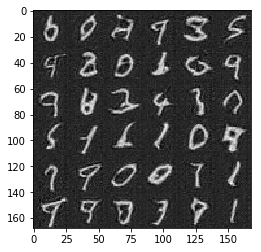

Epoch 2/2... Iteration 1810 Discriminator Loss: 0.6959... Generator Loss: 5.8156
Epoch 2/2... Iteration 1820 Discriminator Loss: 0.9526... Generator Loss: 1.5883
Epoch 2/2... Iteration 1830 Discriminator Loss: 0.9106... Generator Loss: 1.3727
Epoch 2/2... Iteration 1840 Discriminator Loss: 0.8706... Generator Loss: 0.7660
Epoch 2/2... Iteration 1850 Discriminator Loss: 0.5150... Generator Loss: 1.7011
Epoch 2/2... Iteration 1860 Discriminator Loss: 0.7234... Generator Loss: 1.2444
Epoch 2/2... Iteration 1870 Discriminator Loss: 1.2717... Generator Loss: 0.5647


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002

real_size = (28, 28, 1)
alpha = 0.2
beta1 = 0.5

print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

tf.reset_default_graph()

with tf.Graph().as_default():
    net = GAN(real_size, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, 
          print_every=print_every, show_every=show_every)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Iteration 10 Discriminator Loss: 0.9407... Generator Loss: 0.6128
Epoch 1/1... Iteration 20 Discriminator Loss: 2.0005... Generator Loss: 0.2202
Epoch 1/1... Iteration 30 Discriminator Loss: 1.4384... Generator Loss: 0.7736
Epoch 1/1... Iteration 40 Discriminator Loss: 1.5430... Generator Loss: 2.2678
Epoch 1/1... Iteration 50 Discriminator Loss: 1.1389... Generator Loss: 1.2046
Epoch 1/1... Iteration 60 Discriminator Loss: 1.1053... Generator Loss: 0.9186
Epoch 1/1... Iteration 70 Discriminator Loss: 1.6353... Generator Loss: 0.3342
Epoch 1/1... Iteration 80 Discriminator Loss: 1.0722... Generator Loss: 0.7950
Epoch 1/1... Iteration 90 Discriminator Loss: 1.3334... Generator Loss: 0.6622
Epoch 1/1... Iteration 100 Discriminator Loss: 1.5694... Generator Loss: 0.6693


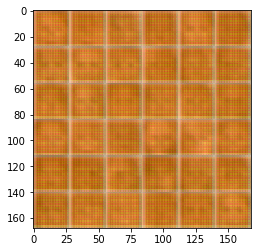

Epoch 1/1... Iteration 110 Discriminator Loss: 1.3045... Generator Loss: 1.5941
Epoch 1/1... Iteration 120 Discriminator Loss: 1.5075... Generator Loss: 0.5144
Epoch 1/1... Iteration 130 Discriminator Loss: 1.4900... Generator Loss: 0.7995
Epoch 1/1... Iteration 140 Discriminator Loss: 1.3032... Generator Loss: 0.7818
Epoch 1/1... Iteration 150 Discriminator Loss: 1.2110... Generator Loss: 0.9671
Epoch 1/1... Iteration 160 Discriminator Loss: 1.5673... Generator Loss: 1.3082
Epoch 1/1... Iteration 170 Discriminator Loss: 1.5059... Generator Loss: 0.5460
Epoch 1/1... Iteration 180 Discriminator Loss: 1.2455... Generator Loss: 0.6365
Epoch 1/1... Iteration 190 Discriminator Loss: 1.6605... Generator Loss: 0.5831
Epoch 1/1... Iteration 200 Discriminator Loss: 1.4224... Generator Loss: 0.6113


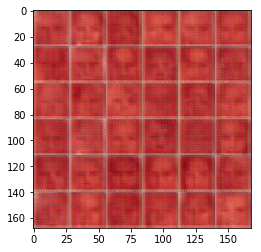

Epoch 1/1... Iteration 210 Discriminator Loss: 1.6304... Generator Loss: 0.5815
Epoch 1/1... Iteration 220 Discriminator Loss: 1.0432... Generator Loss: 0.8373
Epoch 1/1... Iteration 230 Discriminator Loss: 1.4740... Generator Loss: 0.6673
Epoch 1/1... Iteration 240 Discriminator Loss: 2.5603... Generator Loss: 0.6923
Epoch 1/1... Iteration 250 Discriminator Loss: 1.0641... Generator Loss: 0.8655
Epoch 1/1... Iteration 260 Discriminator Loss: 1.2163... Generator Loss: 0.7767
Epoch 1/1... Iteration 270 Discriminator Loss: 1.3097... Generator Loss: 0.6640
Epoch 1/1... Iteration 280 Discriminator Loss: 1.3170... Generator Loss: 0.6223
Epoch 1/1... Iteration 290 Discriminator Loss: 1.0853... Generator Loss: 0.7990
Epoch 1/1... Iteration 300 Discriminator Loss: 1.5109... Generator Loss: 1.3188


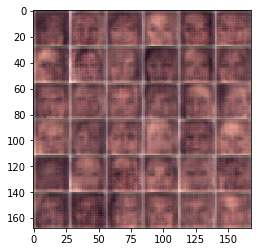

Epoch 1/1... Iteration 310 Discriminator Loss: 1.3224... Generator Loss: 0.7338
Epoch 1/1... Iteration 320 Discriminator Loss: 1.3132... Generator Loss: 0.7634
Epoch 1/1... Iteration 330 Discriminator Loss: 1.1499... Generator Loss: 0.6364
Epoch 1/1... Iteration 340 Discriminator Loss: 1.1996... Generator Loss: 0.8127
Epoch 1/1... Iteration 350 Discriminator Loss: 1.3929... Generator Loss: 0.6643
Epoch 1/1... Iteration 360 Discriminator Loss: 1.4387... Generator Loss: 0.5595
Epoch 1/1... Iteration 370 Discriminator Loss: 1.3160... Generator Loss: 0.6232
Epoch 1/1... Iteration 380 Discriminator Loss: 1.6473... Generator Loss: 0.3567
Epoch 1/1... Iteration 390 Discriminator Loss: 1.1894... Generator Loss: 0.6556
Epoch 1/1... Iteration 400 Discriminator Loss: 1.4177... Generator Loss: 0.7615


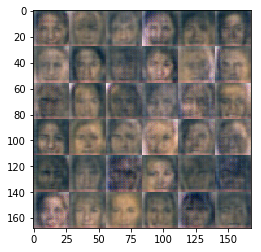

Epoch 1/1... Iteration 410 Discriminator Loss: 2.0667... Generator Loss: 0.2282
Epoch 1/1... Iteration 420 Discriminator Loss: 1.1503... Generator Loss: 0.8968
Epoch 1/1... Iteration 430 Discriminator Loss: 1.4037... Generator Loss: 0.7111
Epoch 1/1... Iteration 440 Discriminator Loss: 1.1791... Generator Loss: 0.7648
Epoch 1/1... Iteration 450 Discriminator Loss: 1.2272... Generator Loss: 1.1275
Epoch 1/1... Iteration 460 Discriminator Loss: 1.3046... Generator Loss: 0.8010
Epoch 1/1... Iteration 470 Discriminator Loss: 1.4272... Generator Loss: 1.0921
Epoch 1/1... Iteration 480 Discriminator Loss: 1.3621... Generator Loss: 0.6297
Epoch 1/1... Iteration 490 Discriminator Loss: 1.5492... Generator Loss: 0.4757
Epoch 1/1... Iteration 500 Discriminator Loss: 1.3220... Generator Loss: 0.6868


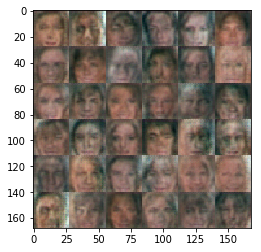

Epoch 1/1... Iteration 510 Discriminator Loss: 1.1271... Generator Loss: 0.8915
Epoch 1/1... Iteration 520 Discriminator Loss: 1.2280... Generator Loss: 0.9265
Epoch 1/1... Iteration 530 Discriminator Loss: 1.9474... Generator Loss: 1.5188
Epoch 1/1... Iteration 540 Discriminator Loss: 1.6578... Generator Loss: 0.4566
Epoch 1/1... Iteration 550 Discriminator Loss: 1.6389... Generator Loss: 0.4265
Epoch 1/1... Iteration 560 Discriminator Loss: 1.3005... Generator Loss: 0.6535
Epoch 1/1... Iteration 570 Discriminator Loss: 1.3713... Generator Loss: 0.8183
Epoch 1/1... Iteration 580 Discriminator Loss: 1.5688... Generator Loss: 0.4789
Epoch 1/1... Iteration 590 Discriminator Loss: 1.2030... Generator Loss: 0.8852
Epoch 1/1... Iteration 600 Discriminator Loss: 1.3612... Generator Loss: 0.7868


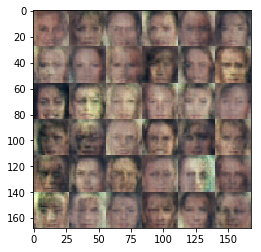

Epoch 1/1... Iteration 610 Discriminator Loss: 1.1705... Generator Loss: 0.8735
Epoch 1/1... Iteration 620 Discriminator Loss: 0.9657... Generator Loss: 0.9424
Epoch 1/1... Iteration 630 Discriminator Loss: 1.2053... Generator Loss: 0.6446
Epoch 1/1... Iteration 640 Discriminator Loss: 1.2808... Generator Loss: 0.7127
Epoch 1/1... Iteration 650 Discriminator Loss: 1.5617... Generator Loss: 0.7226
Epoch 1/1... Iteration 660 Discriminator Loss: 1.8196... Generator Loss: 1.5885
Epoch 1/1... Iteration 670 Discriminator Loss: 1.1841... Generator Loss: 1.0624
Epoch 1/1... Iteration 680 Discriminator Loss: 1.5642... Generator Loss: 0.3704
Epoch 1/1... Iteration 690 Discriminator Loss: 1.4561... Generator Loss: 0.7984
Epoch 1/1... Iteration 700 Discriminator Loss: 1.6121... Generator Loss: 0.3825


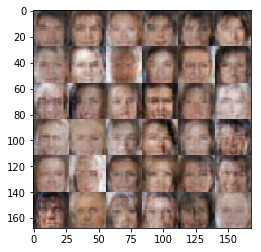

Epoch 1/1... Iteration 710 Discriminator Loss: 1.2364... Generator Loss: 0.7978
Epoch 1/1... Iteration 720 Discriminator Loss: 1.5144... Generator Loss: 0.6895
Epoch 1/1... Iteration 730 Discriminator Loss: 1.0209... Generator Loss: 1.0282
Epoch 1/1... Iteration 740 Discriminator Loss: 1.6854... Generator Loss: 0.5723
Epoch 1/1... Iteration 750 Discriminator Loss: 1.2861... Generator Loss: 0.7214
Epoch 1/1... Iteration 760 Discriminator Loss: 1.2558... Generator Loss: 0.6065
Epoch 1/1... Iteration 770 Discriminator Loss: 1.4210... Generator Loss: 0.6043
Epoch 1/1... Iteration 780 Discriminator Loss: 1.4155... Generator Loss: 1.6155
Epoch 1/1... Iteration 790 Discriminator Loss: 1.2906... Generator Loss: 0.8376
Epoch 1/1... Iteration 800 Discriminator Loss: 1.1993... Generator Loss: 0.8520


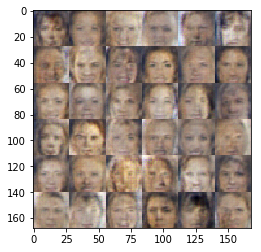

Epoch 1/1... Iteration 810 Discriminator Loss: 1.0998... Generator Loss: 1.3833
Epoch 1/1... Iteration 820 Discriminator Loss: 1.2450... Generator Loss: 0.8146
Epoch 1/1... Iteration 830 Discriminator Loss: 1.2435... Generator Loss: 0.7152
Epoch 1/1... Iteration 840 Discriminator Loss: 1.3213... Generator Loss: 0.7932
Epoch 1/1... Iteration 850 Discriminator Loss: 1.1924... Generator Loss: 0.9091
Epoch 1/1... Iteration 860 Discriminator Loss: 1.3181... Generator Loss: 0.6738
Epoch 1/1... Iteration 870 Discriminator Loss: 1.3083... Generator Loss: 0.8193
Epoch 1/1... Iteration 880 Discriminator Loss: 1.2551... Generator Loss: 0.7292
Epoch 1/1... Iteration 890 Discriminator Loss: 1.2319... Generator Loss: 0.8030
Epoch 1/1... Iteration 900 Discriminator Loss: 1.1954... Generator Loss: 0.7830


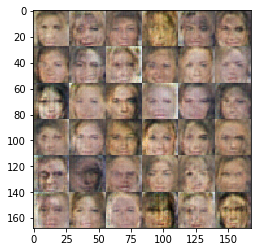

Epoch 1/1... Iteration 910 Discriminator Loss: 1.3789... Generator Loss: 0.6703
Epoch 1/1... Iteration 920 Discriminator Loss: 1.2164... Generator Loss: 1.5326
Epoch 1/1... Iteration 930 Discriminator Loss: 0.9333... Generator Loss: 0.9345
Epoch 1/1... Iteration 940 Discriminator Loss: 1.2997... Generator Loss: 1.6476
Epoch 1/1... Iteration 950 Discriminator Loss: 1.1937... Generator Loss: 1.0340
Epoch 1/1... Iteration 960 Discriminator Loss: 1.2427... Generator Loss: 0.7548
Epoch 1/1... Iteration 970 Discriminator Loss: 0.9507... Generator Loss: 1.4916
Epoch 1/1... Iteration 980 Discriminator Loss: 1.3367... Generator Loss: 0.5042
Epoch 1/1... Iteration 990 Discriminator Loss: 0.9808... Generator Loss: 0.9149
Epoch 1/1... Iteration 1000 Discriminator Loss: 1.0456... Generator Loss: 1.3696


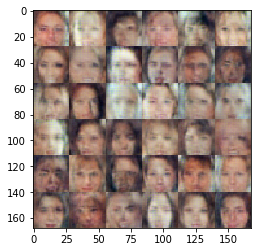

Epoch 1/1... Iteration 1010 Discriminator Loss: 1.2680... Generator Loss: 1.3969
Epoch 1/1... Iteration 1020 Discriminator Loss: 1.1330... Generator Loss: 2.9837
Epoch 1/1... Iteration 1030 Discriminator Loss: 1.1311... Generator Loss: 0.8016
Epoch 1/1... Iteration 1040 Discriminator Loss: 1.0632... Generator Loss: 0.9797
Epoch 1/1... Iteration 1050 Discriminator Loss: 0.7832... Generator Loss: 1.2238
Epoch 1/1... Iteration 1060 Discriminator Loss: 1.8228... Generator Loss: 0.2491
Epoch 1/1... Iteration 1070 Discriminator Loss: 0.9416... Generator Loss: 1.2433
Epoch 1/1... Iteration 1080 Discriminator Loss: 1.2028... Generator Loss: 1.6876
Epoch 1/1... Iteration 1090 Discriminator Loss: 0.7993... Generator Loss: 1.3788
Epoch 1/1... Iteration 1100 Discriminator Loss: 1.6162... Generator Loss: 0.3555


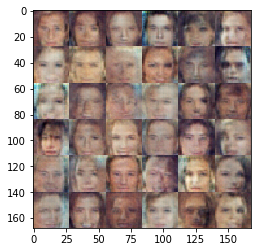

Epoch 1/1... Iteration 1110 Discriminator Loss: 1.3077... Generator Loss: 0.8419
Epoch 1/1... Iteration 1120 Discriminator Loss: 1.1421... Generator Loss: 0.8436
Epoch 1/1... Iteration 1130 Discriminator Loss: 1.2938... Generator Loss: 1.2049
Epoch 1/1... Iteration 1140 Discriminator Loss: 1.1796... Generator Loss: 0.7064
Epoch 1/1... Iteration 1150 Discriminator Loss: 1.1875... Generator Loss: 0.7695
Epoch 1/1... Iteration 1160 Discriminator Loss: 1.0202... Generator Loss: 1.6274
Epoch 1/1... Iteration 1170 Discriminator Loss: 0.9936... Generator Loss: 0.7287
Epoch 1/1... Iteration 1180 Discriminator Loss: 1.1239... Generator Loss: 0.7434
Epoch 1/1... Iteration 1190 Discriminator Loss: 1.3263... Generator Loss: 1.3005
Epoch 1/1... Iteration 1200 Discriminator Loss: 1.2998... Generator Loss: 0.6474


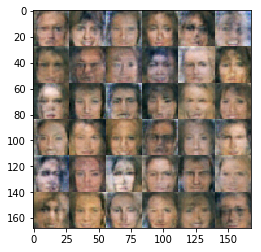

Epoch 1/1... Iteration 1210 Discriminator Loss: 0.8220... Generator Loss: 1.1045
Epoch 1/1... Iteration 1220 Discriminator Loss: 1.3810... Generator Loss: 0.4147
Epoch 1/1... Iteration 1230 Discriminator Loss: 0.8220... Generator Loss: 1.2600
Epoch 1/1... Iteration 1240 Discriminator Loss: 1.2720... Generator Loss: 0.4643
Epoch 1/1... Iteration 1250 Discriminator Loss: 1.0147... Generator Loss: 1.0118
Epoch 1/1... Iteration 1260 Discriminator Loss: 0.8586... Generator Loss: 1.2965
Epoch 1/1... Iteration 1270 Discriminator Loss: 1.1760... Generator Loss: 0.5327
Epoch 1/1... Iteration 1280 Discriminator Loss: 1.0605... Generator Loss: 0.6335
Epoch 1/1... Iteration 1290 Discriminator Loss: 1.3040... Generator Loss: 0.4386
Epoch 1/1... Iteration 1300 Discriminator Loss: 1.3355... Generator Loss: 0.4762


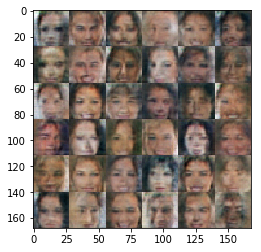

Epoch 1/1... Iteration 1310 Discriminator Loss: 1.0420... Generator Loss: 1.0521
Epoch 1/1... Iteration 1320 Discriminator Loss: 1.6573... Generator Loss: 0.3561
Epoch 1/1... Iteration 1330 Discriminator Loss: 0.9632... Generator Loss: 0.8904
Epoch 1/1... Iteration 1340 Discriminator Loss: 1.3078... Generator Loss: 0.4774
Epoch 1/1... Iteration 1350 Discriminator Loss: 0.9480... Generator Loss: 1.1100
Epoch 1/1... Iteration 1360 Discriminator Loss: 0.8470... Generator Loss: 0.8220
Epoch 1/1... Iteration 1370 Discriminator Loss: 1.7916... Generator Loss: 0.2789
Epoch 1/1... Iteration 1380 Discriminator Loss: 1.5134... Generator Loss: 0.3281
Epoch 1/1... Iteration 1390 Discriminator Loss: 1.2970... Generator Loss: 0.8940
Epoch 1/1... Iteration 1400 Discriminator Loss: 1.3847... Generator Loss: 0.4924


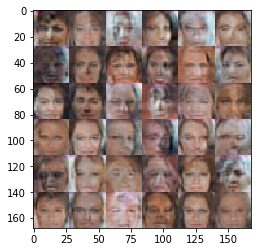

Epoch 1/1... Iteration 1410 Discriminator Loss: 0.8919... Generator Loss: 1.0781
Epoch 1/1... Iteration 1420 Discriminator Loss: 0.7041... Generator Loss: 1.5394
Epoch 1/1... Iteration 1430 Discriminator Loss: 1.3248... Generator Loss: 0.5786
Epoch 1/1... Iteration 1440 Discriminator Loss: 0.9001... Generator Loss: 1.1966
Epoch 1/1... Iteration 1450 Discriminator Loss: 1.1470... Generator Loss: 0.7646
Epoch 1/1... Iteration 1460 Discriminator Loss: 1.0817... Generator Loss: 0.8649
Epoch 1/1... Iteration 1470 Discriminator Loss: 1.0280... Generator Loss: 0.8677
Epoch 1/1... Iteration 1480 Discriminator Loss: 1.1340... Generator Loss: 0.8228
Epoch 1/1... Iteration 1490 Discriminator Loss: 1.0337... Generator Loss: 1.2181
Epoch 1/1... Iteration 1500 Discriminator Loss: 1.0604... Generator Loss: 1.0077


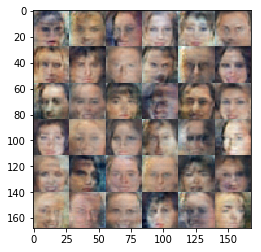

Epoch 1/1... Iteration 1510 Discriminator Loss: 0.9222... Generator Loss: 1.0803
Epoch 1/1... Iteration 1520 Discriminator Loss: 1.1935... Generator Loss: 0.9213
Epoch 1/1... Iteration 1530 Discriminator Loss: 0.7746... Generator Loss: 1.3806
Epoch 1/1... Iteration 1540 Discriminator Loss: 1.0987... Generator Loss: 0.6960
Epoch 1/1... Iteration 1550 Discriminator Loss: 0.8333... Generator Loss: 1.0154
Epoch 1/1... Iteration 1560 Discriminator Loss: 1.0248... Generator Loss: 1.0623
Epoch 1/1... Iteration 1570 Discriminator Loss: 0.9898... Generator Loss: 1.5014
Epoch 1/1... Iteration 1580 Discriminator Loss: 1.3311... Generator Loss: 0.4554
Epoch 1/1... Iteration 1590 Discriminator Loss: 0.7825... Generator Loss: 1.3974
Epoch 1/1... Iteration 1600 Discriminator Loss: 1.0762... Generator Loss: 0.7834


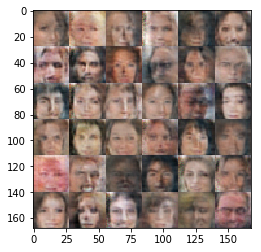

Epoch 1/1... Iteration 1610 Discriminator Loss: 1.1593... Generator Loss: 0.6209
Epoch 1/1... Iteration 1620 Discriminator Loss: 1.1924... Generator Loss: 0.6060
Epoch 1/1... Iteration 1630 Discriminator Loss: 1.2656... Generator Loss: 0.5147
Epoch 1/1... Iteration 1640 Discriminator Loss: 1.1222... Generator Loss: 0.8119
Epoch 1/1... Iteration 1650 Discriminator Loss: 1.1596... Generator Loss: 1.4028
Epoch 1/1... Iteration 1660 Discriminator Loss: 1.0517... Generator Loss: 0.8396
Epoch 1/1... Iteration 1670 Discriminator Loss: 1.3893... Generator Loss: 0.5097
Epoch 1/1... Iteration 1680 Discriminator Loss: 0.9697... Generator Loss: 1.0496
Epoch 1/1... Iteration 1690 Discriminator Loss: 1.5418... Generator Loss: 0.4536
Epoch 1/1... Iteration 1700 Discriminator Loss: 1.1829... Generator Loss: 0.6079


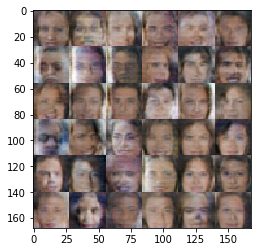

Epoch 1/1... Iteration 1710 Discriminator Loss: 1.4380... Generator Loss: 0.4108
Epoch 1/1... Iteration 1720 Discriminator Loss: 1.2946... Generator Loss: 0.5138
Epoch 1/1... Iteration 1730 Discriminator Loss: 1.2014... Generator Loss: 0.6327
Epoch 1/1... Iteration 1740 Discriminator Loss: 0.8760... Generator Loss: 1.2638
Epoch 1/1... Iteration 1750 Discriminator Loss: 1.1593... Generator Loss: 0.9028
Epoch 1/1... Iteration 1760 Discriminator Loss: 1.1562... Generator Loss: 0.7032
Epoch 1/1... Iteration 1770 Discriminator Loss: 1.0847... Generator Loss: 0.8626
Epoch 1/1... Iteration 1780 Discriminator Loss: 0.9395... Generator Loss: 1.1051
Epoch 1/1... Iteration 1790 Discriminator Loss: 0.9738... Generator Loss: 0.8650
Epoch 1/1... Iteration 1800 Discriminator Loss: 1.0264... Generator Loss: 0.7232


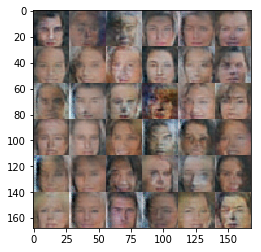

Epoch 1/1... Iteration 1810 Discriminator Loss: 1.2806... Generator Loss: 0.8385
Epoch 1/1... Iteration 1820 Discriminator Loss: 1.4786... Generator Loss: 0.4298
Epoch 1/1... Iteration 1830 Discriminator Loss: 1.3058... Generator Loss: 0.6142
Epoch 1/1... Iteration 1840 Discriminator Loss: 1.2405... Generator Loss: 0.5773
Epoch 1/1... Iteration 1850 Discriminator Loss: 1.0200... Generator Loss: 1.0416
Epoch 1/1... Iteration 1860 Discriminator Loss: 1.1209... Generator Loss: 0.7319
Epoch 1/1... Iteration 1870 Discriminator Loss: 1.1111... Generator Loss: 1.0876
Epoch 1/1... Iteration 1880 Discriminator Loss: 1.2379... Generator Loss: 0.5896
Epoch 1/1... Iteration 1890 Discriminator Loss: 1.1532... Generator Loss: 0.8161
Epoch 1/1... Iteration 1900 Discriminator Loss: 1.4224... Generator Loss: 0.4271


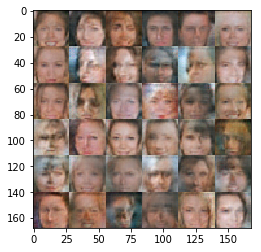

Epoch 1/1... Iteration 1910 Discriminator Loss: 1.2524... Generator Loss: 0.6212
Epoch 1/1... Iteration 1920 Discriminator Loss: 1.0888... Generator Loss: 0.8506
Epoch 1/1... Iteration 1930 Discriminator Loss: 1.0133... Generator Loss: 1.5086
Epoch 1/1... Iteration 1940 Discriminator Loss: 1.2784... Generator Loss: 0.5013
Epoch 1/1... Iteration 1950 Discriminator Loss: 1.1579... Generator Loss: 0.9922
Epoch 1/1... Iteration 1960 Discriminator Loss: 1.0640... Generator Loss: 0.9714
Epoch 1/1... Iteration 1970 Discriminator Loss: 1.0444... Generator Loss: 1.0328
Epoch 1/1... Iteration 1980 Discriminator Loss: 1.0896... Generator Loss: 0.8476
Epoch 1/1... Iteration 1990 Discriminator Loss: 1.1612... Generator Loss: 0.8039
Epoch 1/1... Iteration 2000 Discriminator Loss: 0.9401... Generator Loss: 1.4075


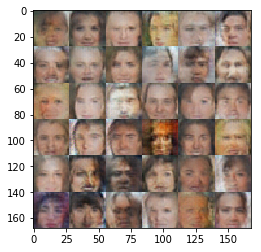

Epoch 1/1... Iteration 2010 Discriminator Loss: 1.2939... Generator Loss: 0.4923
Epoch 1/1... Iteration 2020 Discriminator Loss: 1.0512... Generator Loss: 0.9490
Epoch 1/1... Iteration 2030 Discriminator Loss: 1.3498... Generator Loss: 0.4217
Epoch 1/1... Iteration 2040 Discriminator Loss: 1.1107... Generator Loss: 0.7395
Epoch 1/1... Iteration 2050 Discriminator Loss: 1.4049... Generator Loss: 0.5606
Epoch 1/1... Iteration 2060 Discriminator Loss: 1.2779... Generator Loss: 0.7295
Epoch 1/1... Iteration 2070 Discriminator Loss: 1.0419... Generator Loss: 0.9133
Epoch 1/1... Iteration 2080 Discriminator Loss: 0.9307... Generator Loss: 0.8806
Epoch 1/1... Iteration 2090 Discriminator Loss: 1.3798... Generator Loss: 0.5242
Epoch 1/1... Iteration 2100 Discriminator Loss: 1.0692... Generator Loss: 0.8736


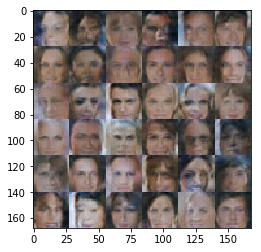

Epoch 1/1... Iteration 2110 Discriminator Loss: 0.9510... Generator Loss: 1.1719
Epoch 1/1... Iteration 2120 Discriminator Loss: 2.3017... Generator Loss: 2.5181
Epoch 1/1... Iteration 2130 Discriminator Loss: 1.0737... Generator Loss: 0.9033
Epoch 1/1... Iteration 2140 Discriminator Loss: 1.0158... Generator Loss: 0.7496
Epoch 1/1... Iteration 2150 Discriminator Loss: 0.8362... Generator Loss: 1.2589
Epoch 1/1... Iteration 2160 Discriminator Loss: 0.8935... Generator Loss: 1.1208
Epoch 1/1... Iteration 2170 Discriminator Loss: 1.2145... Generator Loss: 0.8123
Epoch 1/1... Iteration 2180 Discriminator Loss: 1.1926... Generator Loss: 0.6089
Epoch 1/1... Iteration 2190 Discriminator Loss: 0.9730... Generator Loss: 0.8695
Epoch 1/1... Iteration 2200 Discriminator Loss: 1.1586... Generator Loss: 0.5675


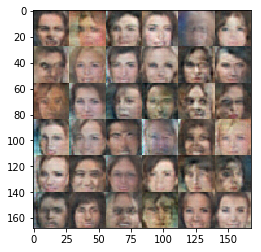

Epoch 1/1... Iteration 2210 Discriminator Loss: 0.9203... Generator Loss: 1.0591
Epoch 1/1... Iteration 2220 Discriminator Loss: 1.0087... Generator Loss: 0.7746
Epoch 1/1... Iteration 2230 Discriminator Loss: 1.0551... Generator Loss: 0.7128
Epoch 1/1... Iteration 2240 Discriminator Loss: 1.1139... Generator Loss: 0.7287
Epoch 1/1... Iteration 2250 Discriminator Loss: 1.1015... Generator Loss: 0.7791
Epoch 1/1... Iteration 2260 Discriminator Loss: 1.1168... Generator Loss: 0.7326
Epoch 1/1... Iteration 2270 Discriminator Loss: 1.1708... Generator Loss: 0.9973
Epoch 1/1... Iteration 2280 Discriminator Loss: 0.9732... Generator Loss: 0.9929
Epoch 1/1... Iteration 2290 Discriminator Loss: 1.2860... Generator Loss: 0.4948
Epoch 1/1... Iteration 2300 Discriminator Loss: 1.1544... Generator Loss: 0.7409


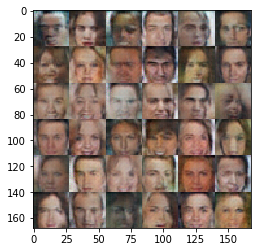

Epoch 1/1... Iteration 2310 Discriminator Loss: 1.0910... Generator Loss: 0.7617
Epoch 1/1... Iteration 2320 Discriminator Loss: 1.7080... Generator Loss: 1.9101
Epoch 1/1... Iteration 2330 Discriminator Loss: 1.0815... Generator Loss: 0.8199
Epoch 1/1... Iteration 2340 Discriminator Loss: 1.0183... Generator Loss: 0.9394
Epoch 1/1... Iteration 2350 Discriminator Loss: 1.1035... Generator Loss: 0.8016
Epoch 1/1... Iteration 2360 Discriminator Loss: 1.1073... Generator Loss: 0.7831
Epoch 1/1... Iteration 2370 Discriminator Loss: 1.4313... Generator Loss: 0.9045
Epoch 1/1... Iteration 2380 Discriminator Loss: 1.0562... Generator Loss: 1.1188
Epoch 1/1... Iteration 2390 Discriminator Loss: 1.0054... Generator Loss: 0.8124
Epoch 1/1... Iteration 2400 Discriminator Loss: 1.0522... Generator Loss: 0.8433


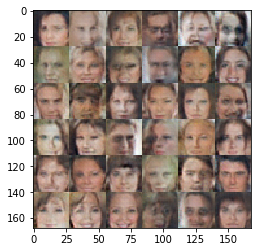

Epoch 1/1... Iteration 2410 Discriminator Loss: 1.2835... Generator Loss: 0.7157
Epoch 1/1... Iteration 2420 Discriminator Loss: 1.1794... Generator Loss: 0.6342
Epoch 1/1... Iteration 2430 Discriminator Loss: 1.2392... Generator Loss: 0.4627
Epoch 1/1... Iteration 2440 Discriminator Loss: 1.0316... Generator Loss: 0.7351
Epoch 1/1... Iteration 2450 Discriminator Loss: 1.0803... Generator Loss: 0.8296
Epoch 1/1... Iteration 2460 Discriminator Loss: 1.3604... Generator Loss: 0.4756
Epoch 1/1... Iteration 2470 Discriminator Loss: 1.0752... Generator Loss: 1.1123
Epoch 1/1... Iteration 2480 Discriminator Loss: 1.0123... Generator Loss: 1.0911
Epoch 1/1... Iteration 2490 Discriminator Loss: 0.9444... Generator Loss: 1.0579
Epoch 1/1... Iteration 2500 Discriminator Loss: 1.6193... Generator Loss: 0.3611


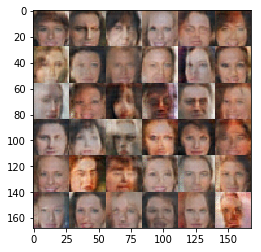

Epoch 1/1... Iteration 2510 Discriminator Loss: 1.2779... Generator Loss: 0.9340
Epoch 1/1... Iteration 2520 Discriminator Loss: 1.0190... Generator Loss: 1.2272
Epoch 1/1... Iteration 2530 Discriminator Loss: 1.1209... Generator Loss: 0.9827
Epoch 1/1... Iteration 2540 Discriminator Loss: 1.2833... Generator Loss: 0.8222
Epoch 1/1... Iteration 2550 Discriminator Loss: 1.3134... Generator Loss: 0.5774
Epoch 1/1... Iteration 2560 Discriminator Loss: 1.0432... Generator Loss: 0.7372
Epoch 1/1... Iteration 2570 Discriminator Loss: 1.1352... Generator Loss: 0.9531
Epoch 1/1... Iteration 2580 Discriminator Loss: 1.5322... Generator Loss: 0.3429
Epoch 1/1... Iteration 2590 Discriminator Loss: 1.1478... Generator Loss: 0.6419
Epoch 1/1... Iteration 2600 Discriminator Loss: 1.0638... Generator Loss: 0.7036


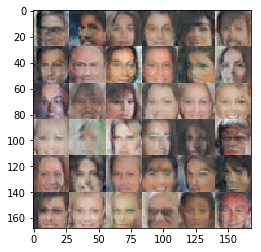

Epoch 1/1... Iteration 2610 Discriminator Loss: 1.0276... Generator Loss: 0.9897
Epoch 1/1... Iteration 2620 Discriminator Loss: 0.8933... Generator Loss: 1.0702
Epoch 1/1... Iteration 2630 Discriminator Loss: 1.2739... Generator Loss: 0.6247
Epoch 1/1... Iteration 2640 Discriminator Loss: 1.3501... Generator Loss: 0.7167
Epoch 1/1... Iteration 2650 Discriminator Loss: 1.1882... Generator Loss: 0.7909
Epoch 1/1... Iteration 2660 Discriminator Loss: 1.3398... Generator Loss: 0.5527
Epoch 1/1... Iteration 2670 Discriminator Loss: 1.2435... Generator Loss: 0.6150
Epoch 1/1... Iteration 2680 Discriminator Loss: 1.0081... Generator Loss: 1.2666
Epoch 1/1... Iteration 2690 Discriminator Loss: 1.3407... Generator Loss: 0.4339
Epoch 1/1... Iteration 2700 Discriminator Loss: 1.0063... Generator Loss: 0.9451


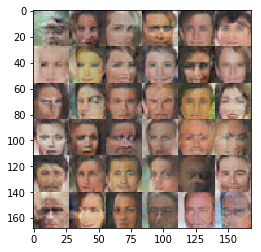

Epoch 1/1... Iteration 2710 Discriminator Loss: 1.2269... Generator Loss: 0.6802
Epoch 1/1... Iteration 2720 Discriminator Loss: 1.0044... Generator Loss: 0.8887
Epoch 1/1... Iteration 2730 Discriminator Loss: 0.9724... Generator Loss: 1.0752
Epoch 1/1... Iteration 2740 Discriminator Loss: 1.0031... Generator Loss: 0.9803
Epoch 1/1... Iteration 2750 Discriminator Loss: 1.1059... Generator Loss: 0.8489
Epoch 1/1... Iteration 2760 Discriminator Loss: 1.4082... Generator Loss: 0.8745
Epoch 1/1... Iteration 2770 Discriminator Loss: 1.0421... Generator Loss: 0.9665
Epoch 1/1... Iteration 2780 Discriminator Loss: 1.0313... Generator Loss: 0.8437
Epoch 1/1... Iteration 2790 Discriminator Loss: 0.9599... Generator Loss: 0.9553
Epoch 1/1... Iteration 2800 Discriminator Loss: 0.9434... Generator Loss: 0.9677


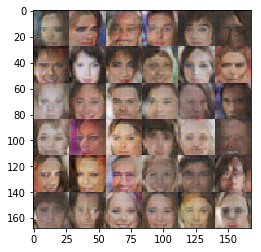

Epoch 1/1... Iteration 2810 Discriminator Loss: 1.5857... Generator Loss: 0.4099
Epoch 1/1... Iteration 2820 Discriminator Loss: 1.1339... Generator Loss: 0.7960
Epoch 1/1... Iteration 2830 Discriminator Loss: 0.8654... Generator Loss: 1.0314
Epoch 1/1... Iteration 2840 Discriminator Loss: 0.9678... Generator Loss: 0.9679
Epoch 1/1... Iteration 2850 Discriminator Loss: 1.1329... Generator Loss: 1.0151
Epoch 1/1... Iteration 2860 Discriminator Loss: 0.9679... Generator Loss: 0.8160
Epoch 1/1... Iteration 2870 Discriminator Loss: 1.0863... Generator Loss: 0.7869
Epoch 1/1... Iteration 2880 Discriminator Loss: 1.1202... Generator Loss: 0.7802
Epoch 1/1... Iteration 2890 Discriminator Loss: 1.2280... Generator Loss: 0.6247
Epoch 1/1... Iteration 2900 Discriminator Loss: 1.2718... Generator Loss: 0.5510


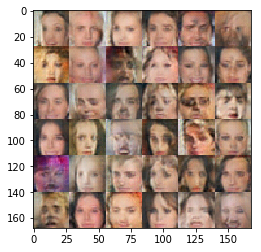

Epoch 1/1... Iteration 2910 Discriminator Loss: 1.1790... Generator Loss: 0.7469
Epoch 1/1... Iteration 2920 Discriminator Loss: 1.2254... Generator Loss: 0.8074
Epoch 1/1... Iteration 2930 Discriminator Loss: 1.1761... Generator Loss: 0.7540
Epoch 1/1... Iteration 2940 Discriminator Loss: 0.9656... Generator Loss: 0.8167
Epoch 1/1... Iteration 2950 Discriminator Loss: 1.1473... Generator Loss: 0.8121
Epoch 1/1... Iteration 2960 Discriminator Loss: 1.4752... Generator Loss: 0.3855
Epoch 1/1... Iteration 2970 Discriminator Loss: 1.2162... Generator Loss: 0.7776
Epoch 1/1... Iteration 2980 Discriminator Loss: 1.3852... Generator Loss: 0.6999
Epoch 1/1... Iteration 2990 Discriminator Loss: 1.2640... Generator Loss: 0.5986
Epoch 1/1... Iteration 3000 Discriminator Loss: 1.1881... Generator Loss: 1.1232


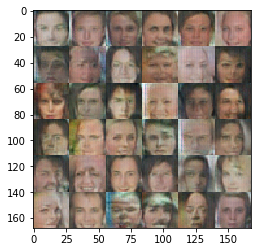

Epoch 1/1... Iteration 3010 Discriminator Loss: 1.1303... Generator Loss: 0.8454
Epoch 1/1... Iteration 3020 Discriminator Loss: 1.2015... Generator Loss: 0.6300
Epoch 1/1... Iteration 3030 Discriminator Loss: 1.1334... Generator Loss: 1.6974
Epoch 1/1... Iteration 3040 Discriminator Loss: 0.9434... Generator Loss: 1.1214
Epoch 1/1... Iteration 3050 Discriminator Loss: 1.1990... Generator Loss: 0.5825
Epoch 1/1... Iteration 3060 Discriminator Loss: 1.2092... Generator Loss: 0.5891
Epoch 1/1... Iteration 3070 Discriminator Loss: 1.0463... Generator Loss: 0.8087
Epoch 1/1... Iteration 3080 Discriminator Loss: 1.0060... Generator Loss: 2.1741
Epoch 1/1... Iteration 3090 Discriminator Loss: 1.0043... Generator Loss: 0.8459
Epoch 1/1... Iteration 3100 Discriminator Loss: 1.4179... Generator Loss: 0.4944


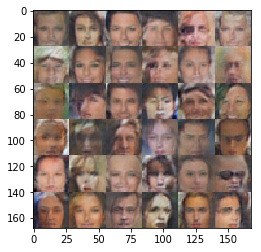

Epoch 1/1... Iteration 3110 Discriminator Loss: 1.2886... Generator Loss: 0.6247
Epoch 1/1... Iteration 3120 Discriminator Loss: 1.1368... Generator Loss: 0.5780
Epoch 1/1... Iteration 3130 Discriminator Loss: 1.3624... Generator Loss: 0.4343
Epoch 1/1... Iteration 3140 Discriminator Loss: 1.0265... Generator Loss: 0.8531
Epoch 1/1... Iteration 3150 Discriminator Loss: 1.4009... Generator Loss: 0.7577
Epoch 1/1... Iteration 3160 Discriminator Loss: 0.9561... Generator Loss: 1.3952


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002

real_size = (28, 28, 3)
epochs = 25
alpha = 0.2
beta1 = 0.5

print_every = 10
show_every = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    net = GAN(real_size, z_dim, learning_rate, alpha=alpha, beta1=beta1)
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,
          print_every=print_every, show_every=show_every)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.